In [1]:
%load_ext notexbook

In [2]:
%texify -fs 18

# Convolutional Neural Network

A convolutional neural network (CNN, or ConvNet) is a type of **feed-forward** artificial neural network in which the connectivity pattern between its neurons is inspired by the organization of the animal visual cortex.

The networks consist of multiple layers of small neuron collections which process portions of the input image, called **receptive fields**. 

The outputs of these collections are then tiled so that their input regions overlap, to obtain a _better representation_ of the original image; this is repeated for every such layer.

## How does it look like?

<img src="figures/convnets_cover.png" width="70%" />

> source: https://flickrcode.files.wordpress.com/2014/10/conv-net2.png

# Prelude

## Data Representation for Machine Learning

_(With very few exceptions)_

In Machine learning data is assumed to be represented by a Matrix of size `[n_samples, n_features]`, namely the **feature matrix**:

$$
{\rm feature~matrix:~~~} {\bf X}~=~\left[
\begin{matrix}
x_{11} & x_{12} & \cdots & x_{1D}\\
x_{21} & x_{22} & \cdots & x_{2D}\\
x_{31} & x_{32} & \cdots & x_{3D}\\
\vdots & \vdots & \ddots & \vdots\\
\vdots & \vdots & \ddots & \vdots\\
x_{N1} & x_{N2} & \cdots & x_{ND}\\
\end{matrix}
\right]
$$

Moreover, in the case of _Supervised learning_ settings, there is also the **label** vector, of size `n_samples`, containing the list of labels for each samples.

$$
{\rm label~vector:~~~} {\bf y}~=~ [y_1, y_2, y_3, \cdots y_N]
$$

In this notation, we are indicating with $N$ the number of samples, and $D$ the number of features.

- $N$ (`n_samples`): each sample is an item to process (e.g. to classify).
  A sample can be a document, a picture, a sound, a video, an astronomical object,
  a row in database or CSV file,
  or whatever you can describe with a fixed set of quantitative traits.
  
- $D$ (`n_features`): features or (*traits*, or *observations*) represent the information that can be used to describe each item in a **quantitative**[$^3$](#fn3) manner. In fact, features are generally **real-valued**, but may also be boolean, **discrete-valued** or any combination of those.

The number of **features** _must_ be fixed in advance.

Each sample (data point) is a row in the feature data array, and each feature **may be** a column 
(if features can be expressed by `1D vector`). 

Features can be also be very high dimensional (e.g. millions of features), but sometimes also very sparse. This is a case where `scipy.sparse` matrices (and `torch.sparse`) [tensors](https://pytorch.org/docs/stable/sparse.html?highlight=torch%20sparse) can be very useful. 

These structures are much more memory-efficient than **dense** `numpy` arrays.

<span id="fn3"><i>[3]</i> Emphasis on **quantitative** here!</span>

<a name="feat-to-numbers"></a>

### Features $\mapsto$ Numbers

Therefore, it is important to keep in mind that **features** must be _ultimately_ **numbers** in order to be processed by a Machine Learning model.

This applies to any format the initial `raw data` may have (e.g. *textual*, *tabular*, *images*); but this sometimes does not even require any further **transformations**[$^4$](#fn4).

<span id="fn4"><i>[4]: </i>Please bear in mind this word when we will later introduce the concept of samples _transformations_ and _transformers_ </span>

<a name="image-example"></a>
#### Example: Image Data

Let's consider the image of this cute little puppy 🐶, for example: 

![🐶](https://github.com/leriomaggio/pytorch-beautiful-ml-data/raw/pydata-global/1_prelude/puppy.jpg)

<span class="fn"><i>Source: </i> [https://cdn.shopify.com/s/files/1/2327/5701/articles/Omega-3-For-Dogs_1200x.jpg](https://cdn.shopify.com/s/files/1/2327/5701/articles/Omega-3-For-Dogs_1200x.jpg)</span>

This image can be indeed represented as a `3D array`: (`channel`, `width`, `height`). In particular this image has `3` channels, namely **R**ed, **G**reen, **B**lue, in the so-called [`RGB`](https://en.wikipedia.org/wiki/RGB_color_model) colour model.

For each channel $C$, every element (i.e. `pixel`) of their $W \times H$ matrix correspond to an intensity value.

<img src="https://e2eml.school/images/image_processing/three_d_array.png" class="maxw30" />

<span class="fn"><i>Source: </i> [https://e2eml.school/images/image_processing/three_d_array.png](https://e2eml.school/images/image_processing/three_d_array.png)</span>

If we now should think of a particular data structure to represent this data, there are so many clues that lead immediately to **NumPy** and `ndarray`: **(1)** contiguous memory with **(2)** fixed-size (i.e. $C \times W \times H$), and **(3)** homogeneous content (i.e. `uint8` or `float`).
This is **no surprise**, and `ndarray` is indeed the main <ins>reference data structure</ins> [expected](https://scikit-learn.org/stable/tutorial/basic/tutorial.html#loading-an-example-dataset) by ML models in `scikit-learn`.

Let's now read this image using `matplotlib` ([`imread`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imread.html)), and see what do we get.

In [3]:
from matplotlib import pyplot as plt
import numpy as np

In [4]:
image = plt.imread("figures/puppy.jpg")
print(f"Image Type: {type(image)}")

Image Type: <class 'numpy.ndarray'>


In [5]:
print("Image shape: (W:{} x H:{} x C:{})".format(*image.shape))

Image shape: (W:630 x H:1200 x C:3)


**Note**: 
In `numpy`, the channel is storead as to the *last* dimension ($W \times H \times C$); whereas in `torch` the channel is expected to be the *first* dimension ($C \times W \times H$).


Let's show `image` using `matplotlib.imshow`...

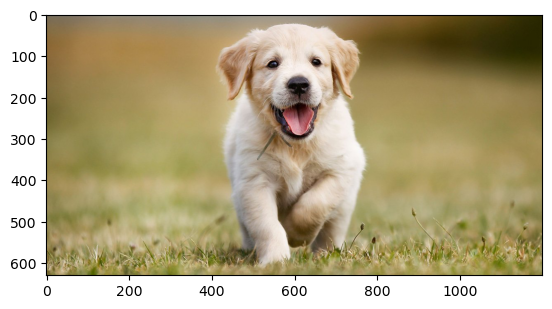

In [6]:
plt.imshow(image)
plt.show()

... and let's also have a look at the actual content of the array

In [7]:
image[:10, :5, 0]  # (with some slicing, for readability)

array([[124, 121, 118, 119, 119],
       [123, 119, 117, 118, 118],
       [124, 120, 117, 118, 118],
       [124, 121, 118, 119, 119],
       [124, 120, 118, 118, 119],
       [123, 119, 117, 118, 118],
       [123, 119, 116, 117, 118],
       [126, 122, 120, 120, 121],
       [124, 120, 118, 119, 120],
       [125, 121, 119, 120, 121]], dtype=uint8)

Let's show the same image per single channel

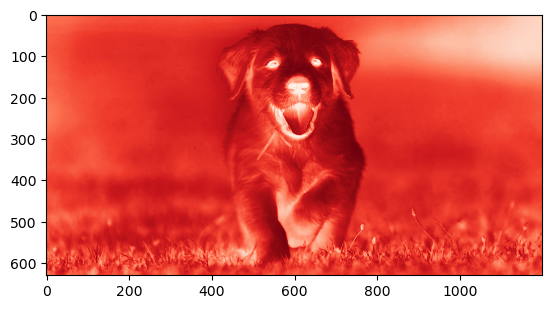

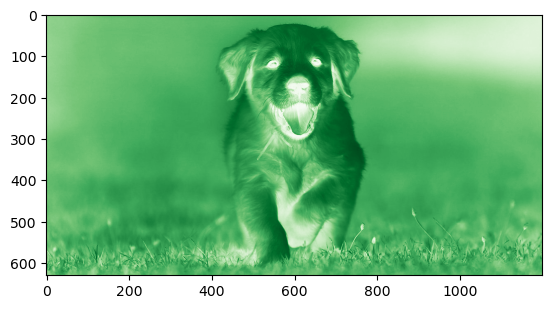

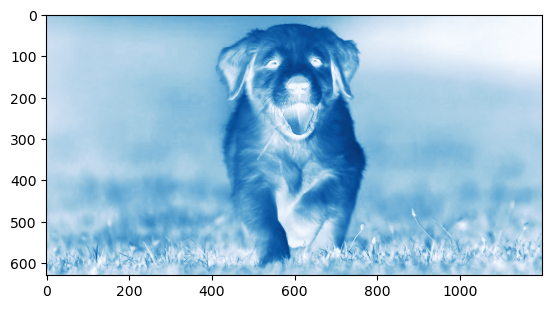

In [8]:
R, G, B = image[..., 0], image[...,1], image[..., 2]
cmaps = ("Reds", "Greens", "Blues")
for channel, colour_map in zip((R, G, B), cmaps):
    plt.imshow(channel, cmap=colour_map)
    plt.show()

... and then back into RGB with the three channels combined as a double check:

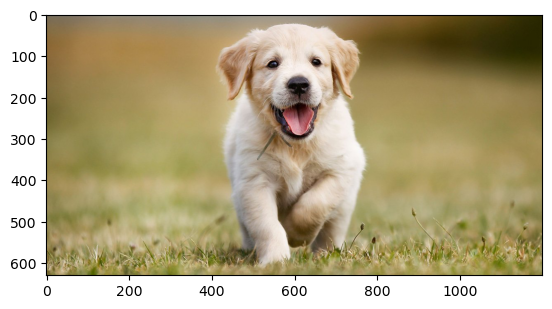

In [9]:
rgb_stack = (np.dstack((R,G,B))).astype(np.uint8)
plt.imshow(rgb_stack)
plt.show()

💡

If now you are thinking something like: 

>(**A.**)"*Hang on, how this matches with the Data Representation model introduced before?* 🤔 
> _You just demonstrated that image pixels are indeed numbers, and so potentially being used as `features` [$^{note}$](#note). However, you also said that Images are `3D-array` objects, so (**B.**) how does having **multiple** ($>2$) dimensions fit with that Representation model?_ 
> (**C.**) _Is this any *special* case or exception to the model?_" 

If that resembles _more or less_ what you are really thinking right now, well...**congrats indeed!!**

The answer to this question will be given in details in the [last](#efficient-numpy) section of this notebook. Short answer for now is: "_No, Images are **no** special case. The model still complies!_"

<span id="note" class="fn"><i>[Note]: </i> This is exactly what it is, especially in the Deep Learning case! </span>

## The Problem Space 

### Image Classification

Image classification is the task of taking an input image and outputting a class (a cat, dog, etc) or a probability of classes that best describes the image. 

For humans, this task of recognition is one of the first skills we learn from the moment we are born and is one that comes naturally and effortlessly as adults.

These skills of being able to quickly recognize patterns, *generalize* from prior knowledge, and adapt to different image environments are ones that we do not share with machines.

#### Inputs and Outputs

<img src="figures/cnn1.png" width="70%" />

<span class="fn"><i>source:</i> [http://www.pawbuzz.com/wp-content/uploads/sites/551/2014/11/corgi-puppies-21.jpg]()</span>

When a computer sees an image (takes an image as input), it will see an array of pixel values. 

Depending on the resolution and size of the image, it will see a 32 x 32 x 3 array of numbers (The 3 refers to RGB values).

let's say we have a color image in JPG form and its size is 480 x 480. The representative array will be 480 x 480 x 3. Each of these numbers is given a value from 0 to 255 which describes the pixel intensity at that point.

#### Goal

What we want the computer to do is to be able to differentiate between all the images it’s given and figure out the unique features that make a dog a dog or that make a cat a cat. 

When we look at a picture of a dog, we can classify it as such if the picture has identifiable features such as paws or 4 legs. 

In a similar way, the computer should be able to perform image classification by looking for *low level* features such as edges and curves, and then building up to more abstract concepts through a series of **convolutional layers**.

### Structure of a CNN

> A more detailed overview of what CNNs do would be that you take the image, pass it through a series of convolutional, nonlinear, pooling (downsampling), and fully connected layers, and get an output. As we said earlier, the output can be a single class or a probability of classes that best describes the image. 

<span class="fn"><i>source:</i> [1]

#### Convolutional Layer

The first layer in a CNN is always a **Convolutional Layer**.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif" class="maxw50">

**Reference**: [https://github.com/vdumoulin/conv_arithmetic](https://github.com/vdumoulin/conv_arithmetic)

#### Convolutional filters



A Convolutional filter much like a **kernel** in image recognition is a small matrix useful for blurring, sharpening, embossing, edge detection, and more. 

This is accomplished by means of convolution between a kernel and an image.

The main goal of CNN is to **learn** the convolutional filters to be applied on images.

As the filter is sliding, or **convolving**, around the input image, it is multiplying the values in the filter with the original pixel values of the image <br>
(a.k.a. computing **element wise multiplications**).

<img src="figures/cnn2.png" class="maxw40" />

Now, we repeat this process for every location on the input volume. (Next step would be moving the filter to the right by 1 unit, then right again by 1, and so on).

After sliding the filter over all the locations, we are left with an array of numbers usually called an **activation map** or **feature map**.

---

### Convolution in a Nutshell

Let’s talk about briefly what this convolution is actually doing from a high level. 

Each of these filters can be thought of as **feature identifiers** (e.g. *straight edges, simple colors, curves*)

<img src="figures/cnn3.png" class="maxw50" />

#### Visualisation of the Receptive Field

<img src="figures/cnn4.png" class="maxw80" />

<img src="figures/cnn5.png" class="maxw80" />

<img src="figures/cnn6.png" class="maxw80" />

The value is much lower! This is because there wasn’t anything in the image section that responded to the curve detector filter. Remember, the output of this conv layer is an activation map. 


---

### Convolution $\mapsto$ Convolutional Neural Networks

Now in a traditional **convolutional neural network** architecture, there are other layers that are interspersed between these conv layers.

<img src="https://adeshpande3.github.io/assets/Table.png"/>

##### ReLU (Rectified Linear Units) Layer

 After each conv layer, it is convention to apply a *nonlinear layer* (or **activation layer**) immediately afterward.


The purpose of this layer is to introduce nonlinearity to a system that basically has just been computing linear operations during the conv layers (just element wise multiplications and summations)

In the past, nonlinear functions like tanh and sigmoid were used, but researchers found out that **ReLU layers** work far better because the network is able to train a lot faster (because of the computational efficiency) without making a significant difference to the accuracy.

It also helps to alleviate the **vanishing gradient problem**, which is the issue where the lower layers of the network train very slowly because the gradient decreases exponentially through the layers

(**very briefly**)

Vanishing gradient problem depends on the choice of the activation function. 

Many common activation functions (e.g `sigmoid` or `tanh`) *squash* their input into a very small output range in a very non-linear fashion. 

For example, sigmoid maps the real number line onto a "small" range of [0, 1].

As a result, there are large regions of the input space which are mapped to an extremely small range. 

In these regions of the input space, even a large change in the input will produce a small change in the output - hence the **gradient is small**.

###### ReLu

The **ReLu** function is defined as $f(x) = \max(0, x),$ [2]

A smooth approximation to the rectifier is the *analytic function*: $f(x) = \ln(1 + e^x)$

which is called the **softplus** function.

The derivative of softplus is $f'(x) = e^x / (e^x + 1) = 1 / (1 + e^{-x})$, i.e. the **logistic function**.


<span class="fn"><i>[2]</i> 
    [http://www.cs.toronto.edu/~fritz/absps/reluICML.pdf]() by G. E. Hinton</span>

#### Pooling Layers

 After some ReLU layers, it is customary to apply a **pooling layer** (aka *downsampling layer*).

In this category, there are also several layer options, with **maxpooling** being the most popular. 

Example of a MaxPooling filter

<img src="figures/MaxPool.png" class="maxw80" />

Other options for pooling layers are average pooling and L2-norm pooling. 

The intuition behind this Pooling layer is that once we know that a specific feature is in the original input volume (there will be a high activation value), its exact location is not as important as its relative location to the other features. 

Therefore this layer drastically reduces the spatial dimension (the length and the width but not the depth) of the input volume.

This serves two main purposes: reduce the amount of parameters; controlling overfitting. 

An intuitive explanation for the usefulness of pooling could be explained by an example: 

Lets assume that we have a filter that is used for detecting faces. The exact pixel location of the face is less relevant then the fact that there is a face "somewhere at the top"

#### Fully Connected Layer

The last layer, however, is an important one, namely the **Fully Connected Layer**.

Basically, a FC layer looks at what high level features most strongly correlate to a particular class and has particular weights so that when you compute the products between the weights and the previous layer, you get the correct probabilities for the different classes.

<img src="figures/ConvNet_LeNet.png" class="maxw50" />

### Going further: Convolution Arithmetic

If you want to go further with Convolution and you want to fully understand how convolution works with all the details we omitted in this notebook, I strongly suggest to read this **terrific** paper: [A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285).

This paper is also referenced (with animations) in the `theano` main documentation: [convnet tutorial](https://github.com/vdumoulin/conv_arithmetic)

---

### Dimensions of Conv filters in

The complex structure of ConvNets *may* lead to a representation that is challenging to understand.

Of course, the dimensions vary according to the dimension of the Convolutional filters (e.g. 1D, 2D)

#### `Convolution1D`

**Input Shape**:

**3D** tensor with shape: (`batch_size`, `steps`, `input_dim`).

**Output Shape**:

**3D** tensor with shape: (`batch_size`, `new_steps`, `filters`).

#### `Convolution2D`

**Input Shape**:

**4D** tensor with shape: 

- (`batch_size`, `channels`, `rows`, `cols`) if `image_data_format='channels_first'`
- (`batch_size`, `rows`, `cols`, `channels`) if `image_data_format='channels_last'`

**Output Shape**:

**4D** tensor with shape:

- (`batch_size`, `filters`, `new_rows`, `new_cols`) 
if `image_data_format='channels_first'`
- (`batch_size`, `new_rows`, `new_cols`, `filters`) if `image_data_format='channels_last'`

**NOTE**: `torch` supports `channels_first` tensor representation by default!

### References:

Some of the images and the content I used came from this great couple of blog posts:

* `[1]` [https://adeshpande3.github.io/adeshpande3.github.io/]();

* `[2]` ["Neural Networks and Deep Learning"](http://neuralnetworksanddeeplearning.com/) by Michael Nielsen. (**Strongly recommend**)  

## Addendum

- [MONAI](https://monai.io/index.html)
    - [MONAI Model Zoo](https://monai.io/model-zoo.html)
- [U-Net for Brain Tumor Segmentation](https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/)